# NLP. Lesson 5. Fully connected language models. Sampling

### Language models
In the previous lesson we considered the statistical language model N-grams. This lesson will be partially dedicated to a special case of Neural Language Models - _Fully connected language model_. There are also Recurrent Neural Networks (RNNs), Long Short-Term Memory Networks (LSTMs), and Transformers.

**Feed-forward language models** for text generation are neural network-based models that generate sequences of text by processing input sequences of words (or characters) through one or more feed-forward layers. These models take a fixed-size context window of preceding words and generate a probability distribution over the possible next words. They are often used in natural language processing tasks such as 
- language modeling, 
- text generation, 
- machine translation

`Context window` - fixed number of preceding words used as input to predict the next word, its size is a parameter of the model.


### Architecture
Feed-forward language models typically consist of the following components:

- **Embedding Layer**: The input sequences of words (or characters) are first converted into dense, low-dimensional vectors called `embeddings` using an embedding layer. Each word in the vocabulary is represented by a unique embedding vector, capturing semantic and syntactic similarities between words based on their context.

- **Feed-forward (Hidden) Layers**: After the input sequences are converted into embeddings, they are passed through one or more feed-forward layers. Each feed-forward layer consists of a sequence of linear transformations followed by activation functions (e.g., ReLU, tanh). These layers capture complex relationships between the input embeddings and produce higher-level representations of the input sequences.
- **Output Layer**: The final layer of the network, which produces a probability distribution over the vocabulary for the next word.

<img src="https://raw.githubusercontent.com/Dnau15/LabImages/main/images/lab05/NeuralNet.png" alt="Language Model" width="800"/>

### The process

1. Given a sequence of words $x_1,x_2, ... ,x_{n−1}$, so a feed-forward language model predicts the next word $x_n$
2. Embedding: Each word $x_i$​ is mapped to an embedding vector $e(x_i)$
3. Concatenation: The embeddings of the context words are concatenated to form a single input vector $\chi$
4. The input vector $\chi$ is passed through one or more hidden layers with activation functions (e.g., ReLU): $ h_1 = ReLU(W_1\chi + b_1)$
5. Output: pass the final hidden layer's output to a softmax function to produce a probability distribution: $y=softmax(W_{out}h_k+b_{out})$

>Loss function: `cross-entropy loss` is tipically used to measure the difference between the predicted probability distribution and the true distribution (one-hot encoding of the actual next word).

> Optimizers: SGD or Adam.


## Model
Lets build the simpliest model to observe how it works

In [1]:
""" For the model implementing we will need a torch package 
    The model consists of 2 layers: embedded where all inputs will
    be converted into vetors and output layer with softmax function """
!pip install torch


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import string

text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: 
once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations 
in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
"""


class CharLanguageModel(nn.Module):
    """ The class for a FNN. Describes all layers inside """
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLanguageModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input)
        output = self.fc(embedded)
        output = self.softmax(output)
        return output


# Prepare training data, define the available set of characters
all_characters = string.printable
n_characters = len(all_characters)


def text_to_tensor(text: str) -> torch.tensor:
    """ Function to convert text to tensor.
        Assume text='abc' and all_characters=[a,b,c,d,...,8,9,0]; the output tensor will be: tensor([1,2,3])
    Args:
        text (str): sequence of chars that should be converted to tensor
    
    Returns:
        tensor (torch.tenssor): tensor with indexes of each char in the text
    """
    tensor = torch.zeros(len(text)).long()  # create an empty tensor
    for c in range(len(text)):
        tensor[c] = all_characters.index(text[c]) # fill it with chars' indexes
    return tensor


def generate_training_example(text: str, chunk_len: int):
    """ Function to generate training examples.
    Assume chunk_len = 4, then one of outputs will be: tensor([28, 29, 14, 27, 94]) tensor([29, 14, 27, 94, 24]).
    Given the input sequence [28, 29, 14, 27, 94] the model supposed to predict the next symbol: 24.
    Args:
        text (str): char sequence based on which the training will be provided
        chunk_len (int): the size of batches/chunks, define how big the context for predicting will be 

    Returns:
        input_seq: tensor: the context
        target_seq: tensor: the context without the 1st char but with a new char 
    """
    start_idx = torch.randint(0, len(text) - chunk_len, (1,))
    end_idx = start_idx + chunk_len + 1
    input_seq = text_to_tensor(text[start_idx:end_idx])
    target_seq = text_to_tensor(text[start_idx+1:end_idx+1])
    return input_seq, target_seq

# Instantiate the model
hidden_size = 100
model = CharLanguageModel(n_characters, hidden_size, n_characters)

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_iters = 10000
print_every = 1000
chunk_len = 10
for i in range(1, n_iters + 1):
    input_seq, target_seq = generate_training_example(text, chunk_len)
    if len(input_seq)!= len(target_seq):
        continue
    optimizer.zero_grad()
    output = model(input_seq.unsqueeze(0))
    loss = criterion(output.squeeze(0), target_seq)
    loss.backward()
    optimizer.step()

    if i % print_every == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')


Iteration 1000, Loss: 1.0306544303894043
Iteration 2000, Loss: 1.5007529258728027
Iteration 3000, Loss: 1.5238550901412964
Iteration 4000, Loss: 1.5764747858047485
Iteration 5000, Loss: 1.3510743379592896
Iteration 6000, Loss: 1.3989815711975098
Iteration 7000, Loss: 1.1142727136611938
Iteration 8000, Loss: 1.2031887769699097
Iteration 9000, Loss: 1.2877799272537231
Iteration 10000, Loss: 1.06586754322052


In [3]:
def generate_text(start_string='Hello', predict_len=100, temperature=0.9) -> str:
    """ Function to generate text using the trained model.

    Args:
        start_string (str, optional): The first word for text generation. Defaults to 'Hello'.
        predict_len (int, optional): The length of a generated text. Defaults to 100.
        temperature (float, optional): degree of freedom for softmax. Defaults to 0.9.

    Returns:
        output_str (str): generated text
    """
    model.eval()
    input_seq = text_to_tensor(start_string)
    hidden = torch.zeros(1, hidden_size)
    output_str = start_string

    for _ in range(predict_len):
        output = model(input_seq.unsqueeze(0))
        output_dist = output.squeeze(0)[-1].div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_char = all_characters[top_i]
        output_str += predicted_char
        input_seq = text_to_tensor(predicted_char)
    
    return output_str

# Generate text
generated_text = generate_text(start_string='Alice', predict_len=50)
print(generated_text)


AliceD{q-9#E`P=N[6c
>#{+JC	3V(oX*S?Dp6w


## Perplexity

How to evaluate 2 models (A and B) and compare them?

**Extrinsic** evaluation: put each model in a real task, run the task, get a score for A and for B, compare accuracy for A and B.
- Expensive and time-consuming
- Doesn't always generalize to other applications

**Intrinsic** evaluation: perplexity

`Perplexity` is a measure of how well a language model predicts a given sequence of words. Perplexity is defined as the exponentiated average negative log-likelihood of a sequence. It directly measures language model performance at predicting words, doesn't necessarily correspond with real application performance, but gives us a single general metric for language models. Also is used in **N-grams evaluation**.

If we have a tokenized sequence $X = (x_0, x_1, \dots, x_t)$, then the perplexity of $X$ is,

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

where $\log p_\theta (x_i|x_{<i})$ is the log-likelihood of the ith token conditioned on the preceding tokens $x_{<i}$ according to our model. 

Intuitively, it can be thought of as an evaluation of the model's ability to predict uniformly among the set of specified tokens in a corpus. Importantly, this means that the tokenization procedure has a direct impact on a model's perplexity which should always be taken into consideration when comparing different models.

>Lower perplexity indicates a better-performing model, as it suggests that the model is more confident in its predictions and assigns higher probabilities to the actual next words in the sequence.

>Higher perplexity assumes that the model is less confident in its predictions and assigns lower probabilities to the actual next words.

### Example
Suppose we have a language model and a test sequence "hello world". Let's denote the probabilities assigned by the model as:

$P(x_0 = "hello") = 0.2$
$P(x_1="world"|x_0="hello")=0.5$

The `log-likelihood` for this sequence is:  $log P("hello") + log P("world"|"hello") = log(0.2)+log(0.5) ≈ −1.609 + (−0.693)$

The average log-likelyhood: $\frac{−1.609 −0.693}{2} = -1.151$

The exponentiating: $PPL("hello\ world")=\exp{-1.151} ≈ 3.16$

Lets turn back to the N-grams and explore the Perplexity in work:

In [4]:
import nltk
from nltk.util import ngrams
from collections import Counter

nltk.download('punkt')
# Sample text data
text = "This is a sample text used for demonstration purposes. This is demonstration is is is is a a a with two sentences and This. this a demonstration text text"
text = text.lower()

# Tokenize the text
tokens = nltk.word_tokenize(text)

# Generate n-grams
n = 3  # Choose the order of n-gram model
n_grams = list(ngrams(tokens, n))

# Count the occurrences of each n-gram
n_gram_counts = Counter(n_grams)

print("Sample n-grams and their counts:")
for n_gram, count in n_gram_counts.most_common(5):
    print(n_gram, "->", count)

# Calculate probabilities for each n-gram: create a dictionary in format (a tuple with 3 words) : probability
total_n_grams = sum(n_gram_counts.values())
n_gram_probs = {n_gram: count / total_n_grams for n_gram, count in n_gram_counts.items()}


def predict_next_word(sequence: str) -> dict:
    """ Function to predict the next word given a sequence of words.

    Args:
        sequence (str): string for which we need to find 
                        probabilities for some (not every) word to be the next one
    Returns:
        next_word_probs: dict: probabilities for some word to be the next one
    """
    next_word_probs = {}
    for n_gram, prob in n_gram_probs.items():
        # if the n_gram contains a given sequence -> 
        # add the next after the sequence word and its probability to the dictionary
        if n_gram[:-1] == sequence:
            next_word_probs[n_gram[-1]] = prob
    return next_word_probs

# Example usage:
sequence = ('is', 'a')
next_word_probs = predict_next_word(sequence)
print("Next word probabilities:", next_word_probs)


Sample n-grams and their counts:
('is', 'is', 'is') -> 2
('this', 'is', 'a') -> 1
('is', 'a', 'sample') -> 1
('a', 'sample', 'text') -> 1
('sample', 'text', 'used') -> 1
Next word probabilities: {'sample': 0.034482758620689655, 'a': 0.034482758620689655}


### Task 1.
Lets find the perplexity for this n-gram model. The perplexity here can be found as:
$$PPL(X) = (\prod_{i=1}^M\frac{1}{P(x_i)})^{1/M}$$
where M is the number of n-grams in teh text and $P(x_i)$ is the probability of the i-th n-gram according to the language model.

In [5]:
test_text = "This is a test text."

# Tokenize the test text
test_tokens = ...

# Generate n-grams for the test text
test_n_grams = ...

# Calculate perplexity
perplexity = 1
for n_gram in test_n_grams:
    if n_gram in n_gram_probs:
        perplexity *= ...
perplexity = ...

print("Perplexity of the language model:", perplexity)


Perplexity of the language model: 1.0


In [6]:
# Function from the previous lesson
def almost_equal(x,y,threshold=0.0001):
  return abs(x-y) < threshold

In [7]:
assert almost_equal(perplexity, 1, 0.00001)

### Task 2.

Compute the probabilities for each word from the `text` variable (divide a number of its occurences by the total words number). Be careful, the produced variable `probs` will be used in further tasks. Do not forget the lowecasing.

In [8]:
# lowercase
text = ...

# tokenize the text
tokens = ...

# count the number of each word occurences, use the Counter class from 'collections' module
# you will need counts.values() and count.items() methods
counts = ...
total_sum = ...
probs = ...
probs

{'this': 0.12903225806451613,
 'is': 0.1935483870967742,
 'a': 0.16129032258064516,
 'sample': 0.03225806451612903,
 'text': 0.0967741935483871,
 'used': 0.03225806451612903,
 'for': 0.03225806451612903,
 'demonstration': 0.0967741935483871,
 'purposes': 0.03225806451612903,
 '.': 0.06451612903225806,
 'with': 0.03225806451612903,
 'two': 0.03225806451612903,
 'sentences': 0.03225806451612903,
 'and': 0.03225806451612903}

In [9]:
assert almost_equal(probs['for'], 0.032258, 0.000001)

## Decoding Strategies

Decoding strategies dictate how a language model selects the next token in a sequence after predicting probabilities for all possible tokens.
- Deterministic strategies choose the most probable next token at each step, ensuring predictability but often at the expense of diversity (Greedy decoding, Beam search, Contrastive search). 
- Stochastic strategies introduce randomness into the selection process, aiming for more varied and creative outputs but with less predictability (Multinomial sampling, Top-k sampling, Top-p (Nucleus) sampling, Beam search with multinomial sampling).

### Greedy Decoding
The simplest strategy: it selects the token with the highest probability as predicted by the model.
- Efficient, straightforward and fast.
- Repetitive: tends to produce repetitive and predictable text. Lack of foresight, leads to suboptimal and less coherent results.
- Useful in scenarios where speed is **critical** and the quality of the generated text is not the top priority. May be a baseline to compare more sophisticated decoding methods.

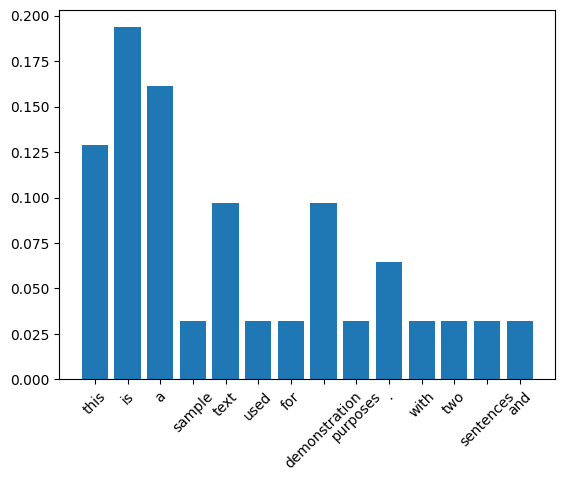

In [10]:
import matplotlib.pyplot as plt

plt.bar(probs.keys(), probs.values())
plt.xticks(rotation=45)

plt.show()

### Task 3. 
Implement the beginning of the greedy search. Find a word with the highest probability in the `probs` dictionary.

In [11]:
import numpy as np

def greedy_search(probabilities: dict[str, float]) -> str:
    ...

In [12]:
greedy_search(probs)

'is'

In [13]:
assert greedy_search(probs) == 'is' 

### Top-k Sampling
Involves selecting the next word from the top-k most probable candidates rather than always choosing the highest-probability word. This introduces a level of randomness that can produce more diverse and creative text.

By adjusting the value of k, we can control the level of diversity in the generated text. A smaller k results in less diversity and more predictable text, while a larger k increases the variability and creativity of the output.

The model:
1. chooses top k the most probable results
2. sample among k the best results with adjusted probabilities

- Preventing the model from getting stuck in repetitive or generic patterns. Variate and random results, while the random degree might be controlled.
- Large k might lead to less coherent and contextually appropriate generated text. With k increasing, the computational requirements increase as the model must consider more candidates at each step.
- Useful in storytelling, poetry generation, and dialogue systems.


![Top K](https://raw.githubusercontent.com/Dnau15/LabImages/main/images/lab05/TopK.png)

<img src="https://raw.githubusercontent.com/Dnau15/LabImages/main/images/lab05/adjProbs.png" alt="Adjacent Probabilities" width="500"/>

GPT2 adopted this sampling scheme, which was one of the reasons for its success in story generation.

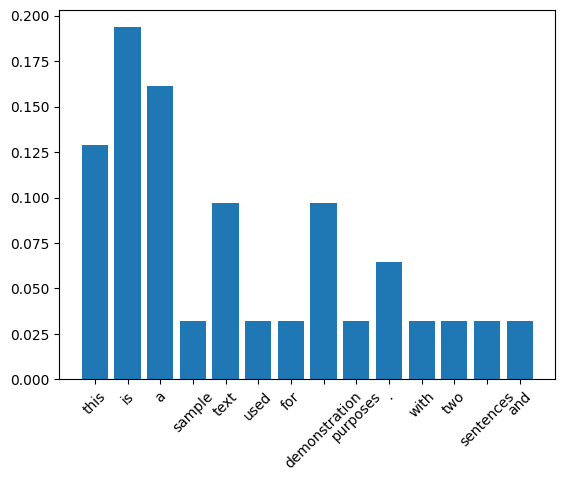

In [14]:
import matplotlib.pyplot as plt

plt.bar(probs.keys(), probs.values())
plt.xticks(rotation=45)
plt.show()

### Task 4.
Select top 5 the highest-probable words among "probs".

In [15]:
top_5 = ...
top_5

{'is': 0.1935483870967742,
 'a': 0.16129032258064516,
 'this': 0.12903225806451613,
 'text': 0.0967741935483871,
 'demonstration': 0.0967741935483871}

In [16]:
assert len(top_5) == 5
assert almost_equal(top_5['text'], 0.09677, 0.00001) 

### Task 5.
Complete the softmax function. 


In [17]:
def softmax(z: list[float]) -> list[float]:
   return ...

In [18]:
assert almost_equal(softmax([1, 2, 5])[0], 0.017147, 0.000001)

### Task 6.
Continue the top-k sampling method implementation. Adjust the probabilities among 5 words and plot the histogram for their distribution.

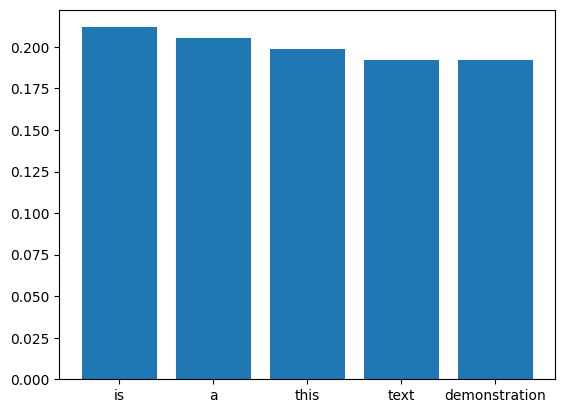

{'is': 0.21180608864202488,
 'a': 0.20508265958737557,
 'this': 0.19857265451190803,
 'text': 0.19226929862934583,
 'demonstration': 0.19226929862934583}

In [19]:
reweighted_probs = ...
plt.bar(...)
plt.show()
reweighted_probs

In [20]:
assert almost_equal(reweighted_probs['demonstration'], 0.192269, 0.000001)

### Task 7.

Finish the top-k method. Choose the final word that will be generated (randomly, but with the fixes random seed, with corresponding adjusted probabilities). `Hint:` use numpy.random.choice(list, p) where p - probabilities for each list's entity.

In [21]:
import numpy as np

np.random.seed(0)
sampled_token = ...
print(sampled_token)

this


In [22]:
assert sampled_token == 'this'

### Beam search

The beam search algorithm selects multiple tokens for a position in a given sequence based on conditional probability. 

It is an optimization of the best-first search that explores a graph by expanding the most promising node in a limited set, called a `"beam"`. Beam search helps to manage the trade-off between breadth and depth of the search, making it more efficient than a naive breadth-first search and more comprehensive than a greedy search.

The algorithm can take any number of N best alternatives through a hyperparameter know as a `Beam width`. In greedy search we simply took the best word for each position in the sequence, where here we broaden our search or "width" to include other words that might fit better.

Greedy search looks at each position in the output sequence in isolation. A word is decided based on highest probability and we continue moving down the rest of the sentence, not going back to earlier ones. With Beam search, we also take the N best output sequences and look at the current preceding words and the probabilities compared to the current position we are decoding in the sequence.

The algorithm:
1. Initialization: Start with the initial state (e.g., the beginning of a sentence or sequence) and place it in the beam.
2. Expansion: For each state in the beam, expand it by generating all possible next states (e.g. next words in the sequence). Compute a score (log probability) for each new state based on the model.
3. Pruning: Select the top $k$ states with the highest scores and keep them in the beam. The value of $k$ is the beam width and is a parameter of the search.
4. Repeat: Repeat the expansion and pruning steps until a stopping criterion is met (end-of-sequence token is generated, maximum sequence length is reached, etc.).
5. Selection: Select the highest-scoring state from the beam as the final output.

![](https://raw.githubusercontent.com/Dnau15/LabImages/main/images/lab05/Beam_search.gif)

In [23]:
def beam_search(seed_sequence: list[str], beam_width: int, max_length: int) -> list[list[list, int]]:
    """ Function implementing the beam search

    Args:
        seed_sequence (list of strings): the initial string for which the function supposed to find a continuation
        beam_width (int): beam search parameter, 
            how wide the tree should be, how many the best continuations should be taken
        max_length (int): beam search parameter, how long the search should be

    Returns:
        sequences (list): contains some lists which include a list with a 
            seed_sequence + `new word` and a probability the new sequence to be like this
    """
    sequences = [[list(seed_sequence), 1.0]]
    for _ in range(max_length):
        next_sequences = []
        for seq, score in sequences:
            next_word_probs = predict_next_word(tuple(seq[-(n-1):]))
            for next_word, next_word_prob in next_word_probs.items():
                new_seq = seq + [next_word]
                new_score = score * next_word_prob
                next_sequences.append([new_seq, new_score])
        next_sequences.sort(key=lambda x: x[1], reverse=True)
        sequences = next_sequences[:beam_width]
    return sequences

# Example usage:
seed_sequence = ['this', 'is']
generated_sequences = beam_search(seed_sequence, beam_width=3, max_length=5)
print("Generated sequences:")
for seq, score in generated_sequences:
    print(" ".join(seq), "-> Score:", score)


Generated sequences:
this is a sample text used for -> Score: 4.875397277841431e-08
this is a a a a a -> Score: 4.875397277841431e-08
this is a a a a with -> Score: 4.875397277841431e-08


# Conclusion

In this lesson we covered essential topics in natural language processing (NLP) related to language models. Here are the key takeaways:
- Fully Connected Language Models for predicting the next word in a sequence, used in crucial for tasks like text generation and machine translation. Also we built the simplest model for text generation
- Perplexity - metric to evaluate model performance, lower perplexity indicates better predictions. We had a look on perplexity evaluation for n-grams model.
- Decoding strategies or `Sampling methods`: 
    - Greedy search - the most straightforward technique
    - Top-k sampling - technique with increased variability, because the final word is chosen among k words, but not always the "best" one. 
    - Beam search - heuristic search algorithm for sequence generation, balances efficiency and accuracy.

By mastering these concepts, you now have a solid foundation in building and evaluating language models. 

**References and additional reading:**

https://github.com/kmkarakaya/Deep-Learning-Tutorials/blob/master/Sampling_in_Text_Generation.ipynb

https://deci.ai/blog/from-top-k-to-beam-search-llm-decoding-strategies/ 

https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277